In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import feather
from datetime import date, datetime
import joblib

In [6]:
data_path = '/Volumes/FileStorage/Insight_data/'
ohio_path = '/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/'

In [7]:
oh_df=feather.read_dataframe('/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/oh_census_df.feather')

In [9]:
model = joblib.load('logreg_fulldata_census.joblib')

In [10]:
features=['PARTY_AFFILIATION','STATE_REPRESENTATIVE_DISTRICT','PRECINCT_NAME','AGE_2020','GENERAL-11/08/2016','RATIO_2020','HC02_EST_VC17','HC02_EST_VC18']
model_features=['AGE_2020','GENERAL-11/08/2016','RATIO_2020','HC02_EST_VC17','HC02_EST_VC18']

In [11]:
df_X=oh_df.loc[:, features]

In [12]:
df_X['PARTY_AFFILIATION']=df_X['PARTY_AFFILIATION'].fillna('N')

In [13]:
df_X.groupby('PARTY_AFFILIATION').size()

PARTY_AFFILIATION
D    1338397
G       6775
L         23
N    4563298
R    1916892
dtype: int64

In [14]:
N=4563298
D=1338397
G=6775
L=23
R=1916892

tot_p=N+D+G+L+R

In [15]:
tot_p

7825385

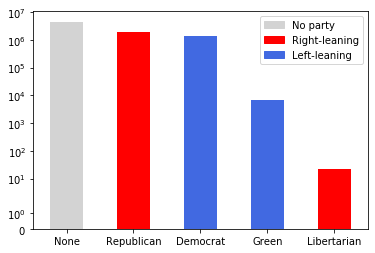

In [16]:
import matplotlib.patches as mpatches

s=pd.Series([N,R,D,G,L],index=['None','Republican','Democrat','Green','Libertarian'])
c=['lightgrey','red','royalblue','royalblue','red']
s.plot(kind='bar',color=c)
plt.xticks(rotation=360)
nopref=mpatches.Patch(color='lightgrey', label='No party')
right=mpatches.Patch(color='red',label='Right-leaning')
left=mpatches.Patch(color='royalblue',label='Left-leaning')
plt.legend(handles=[nopref,right,left])
axes = plt.gca()
plt.yscale('symlog')
#axes.set_ylim([0,ymax])
plt.show()

In [17]:
df_X_model=oh_df.loc[:, model_features]

In [18]:
df_Y_model=model.predict(df_X_model)

In [19]:
df_Y_model.shape

(7825385,)

In [20]:
df_results=df_X
df_results['2020_pred']=df_Y_model

In [21]:
df_results.head()

,PARTY_AFFILIATION,STATE_REPRESENTATIVE_DISTRICT,PRECINCT_NAME,AGE_2020,GENERAL-11/08/2016,RATIO_2020,HC02_EST_VC17,HC02_EST_VC18,2020_pred
0,N,82,PRECINCT ST. MARYS 3A,50,-1,0.057143,90.5,15.7,-1
1,N,53,MONROE 2,45,0,0.257143,94.9,35.4,0
2,N,9,CLEVELAND-02-Q,49,-1,0.000000,78.6,9.9,-1
3,N,65,MIAMI TOWNSHIP X,47,0,0.171429,94.9,46.6,0
4,N,12,CLEVELAND-01-E,45,0,0.333333,85.5,14.0,0


In [22]:
feather.write_dataframe(df_results,'/Volumes/FileStorage/Insight_data/Ohio_data/data_feather/results.feather')
feather.write_dataframe(df_results,'/Users/kristinalooper/WorkArea/insight/results.feather')

In [23]:
df_results['2020_pred'].replace(-1, np.nan,inplace=True)
df_results['2020_pred'].replace(0,1,inplace=True)

In [24]:
prec_votes = df_results.groupby(['STATE_REPRESENTATIVE_DISTRICT','PRECINCT_NAME'])['2020_pred'].sum()

In [25]:
sorted_votes=prec_votes.reset_index().sort_values(['STATE_REPRESENTATIVE_DISTRICT','2020_pred'],ascending=[True,False]).set_index(['STATE_REPRESENTATIVE_DISTRICT','PRECINCT_NAME'])

In [26]:
#sorted_votes=sorted_votes.reset_index().set_index(['STATE_REPRESENTATIVE_DISTRICT','PRECINCT_NAME'])
sorted_votes.index.get_level_values(1)

Index(['WOOSTER CITY 4-C', 'WOOSTER CITY 3-C', 'WOOSTER CITY 4-D',
       'ORRVILLE CITY 3', 'WAYNE TWP 1', 'SUGAR CREEK TWP 1',
       'SUGAR CREEK TWP 2', 'SUGAR CREEK TWP 3 DALTON', 'CHESTER TWP 1',
       'RITTMAN CITY 3',
       ...
       'PRECINCT ASHTABULA 3-B', 'PRECINCT ASHTABULA 2-D',
       'PRECINCT ASHTABULA 4-B', 'PRECINCT ASHTABULA 3-C',
       'PRECINCT ASHTABULA 4-A', 'PRECINCT CONNEAUT 4-C',
       'PRECINCT ASHTABULA 5-A', 'PRECINCT ASHTABULA 5-B',
       'PRECINCT AQUILLA VILLAGE', 'PRECINCT ASHTABULA 3-A'],
      dtype='object', name='PRECINCT_NAME', length=9063)

In [27]:
#sorted_votes['2020_pred'].nlargest(3)
top_sorted=sorted_votes['2020_pred'].groupby(level='STATE_REPRESENTATIVE_DISTRICT').nlargest(3).reset_index(level=0, drop=True).reset_index(level=1)
#top_sorted=sorted_votes.groupby('STATE_REPRESENTATIVE_DISTRICT')['2020_pred'].nlargest(3)

In [28]:
top_dict=dict(top_sorted.groupby('STATE_REPRESENTATIVE_DISTRICT')['PRECINCT_NAME'].apply(list))

In [29]:
top_dict[1]

['WOOSTER CITY 4-C', 'WOOSTER CITY 3-C', 'WOOSTER CITY 4-D']

In [30]:
party_df=df_results.groupby(['PRECINCT_NAME','PARTY_AFFILIATION']).size()
#party_dict=df_results.groupby(['PRECINCT_NAME','PARTY_AFFILIATION']).size().to_dict()
#party_sort=df_results.groupby(['PRECINCT_NAME','PARTY_AFFILIATION']).size().reset_index()#.set_index(['PRECINT_NAME','PARTY_AFFILIATION'])


In [31]:
df_test = df_results
df_test.head(10)

,PARTY_AFFILIATION,STATE_REPRESENTATIVE_DISTRICT,PRECINCT_NAME,AGE_2020,GENERAL-11/08/2016,RATIO_2020,HC02_EST_VC17,HC02_EST_VC18,2020_pred
0,N,82,PRECINCT ST. MARYS 3A,50,-1,0.057143,90.5,15.7,NaN
1,N,53,MONROE 2,45,0,0.257143,94.9,35.4,1.0
2,N,9,CLEVELAND-02-Q,49,-1,0.000000,78.6,9.9,NaN
3,N,65,MIAMI TOWNSHIP X,47,0,0.171429,94.9,46.6,1.0
4,N,12,CLEVELAND-01-E,45,0,0.333333,85.5,14.0,1.0
5,D,16,NORTH OLMSTED-02-C,41,0,0.228571,92.1,29.8,1.0
6,N,65,WAYNE TOWNSHIP B,77,0,0.257143,87.8,13.8,1.0
7,R,64,PRECINCT WMSFLD TWP 2,77,0,0.344828,85.1,10.5,1.0
8,N,65,MIAMI TOWNSHIP L1L,48,-1,0.074074,94.9,46.6,1.0
9,N,12,PEPPER PIKE-00-D,28,0,0.200000,95.7,48.2,1.0


In [32]:
#df = df.groupby(['A', 'B']).size().reset_index(name='Size')
df_test=df_test.groupby(['PRECINCT_NAME','PARTY_AFFILIATION']).size().reset_index(name='Size')

In [33]:
df_test.head(10)

,PRECINCT_NAME,PARTY_AFFILIATION,Size
0,ABERDEEN VILLAGE,D,136
1,ABERDEEN VILLAGE,G,1
2,ABERDEEN VILLAGE,N,667
3,ABERDEEN VILLAGE,R,292
4,ADA NORTH,D,133
5,ADA NORTH,G,2
6,ADA NORTH,N,794
7,ADA NORTH,R,232
8,ADA SOUTH,D,102
9,ADA SOUTH,G,1


In [34]:
party_rows=df_test.set_index(['PRECINCT_NAME', 'PARTY_AFFILIATION']).unstack(['PARTY_AFFILIATION'])

In [35]:
party_rows=party_rows.reset_index()

In [36]:
party_rows=party_rows.fillna(0)

In [37]:
party_rows

PRECINCT_NAME   Size                          
PARTY_AFFILIATION                        D     G    L       N      R
0                  ABERDEEN VILLAGE  136.0   1.0  0.0   667.0  292.0
1                         ADA NORTH  133.0   2.0  0.0   794.0  232.0
2                         ADA SOUTH  102.0   1.0  0.0   764.0  301.0
3                           ADAMS A   58.0   1.0  0.0   253.0  333.0
4                           ADAMS B   64.0   0.0  0.0   395.0  358.0
5                         ADAMS TWP   76.0   0.0  0.0   284.0  308.0
6                       ADDISON PCT   69.0   0.0  0.0   340.0  164.0
7                       ADDISON TWP   95.0   0.0  0.0   416.0  282.0
8                        ADDYSTON A   48.0   4.0  0.0   381.0  113.0
9                         AKRON 1-A  162.0   0.0  0.0   561.0   30.0
10                        AKRON 1-B   25.0   0.0  0.0   461.0    4.0
11                        AKRON 1-C  375.0   1.0  0.0   532.0   87.0
12                        AKRON 1-D  291.0   0.0  0.0   543.0   42.0
13                        AKRON 1-E  205.0   2.0  0.0   385.0  349.0
14                        AKRON 1-F  226.0   0.0  0.0   647.0  126.0
15                        AKRON 1-G  366.0   2.0  0.0   464.0   99.0
16                        AKRON 1-H  200.0   1.0  0.0   894.0   81.0
17                        AKRON 1-I  432.0   0.0  0.0   402.0  195.0
18                        AKRON 1-J  369.0   2.0  0.0   457.0  202.0
19                        AKRON 1-K  377.0   0.0  0.0   480.0  108.0
20                        AKRON 1-L  224.0   0.0  0.0   665.0   42.0
21                        AKRON 1-M   47.0   0.0  0.0   753.0   11.0
22                       AKRON 10-A  168.0   1.0  0.0   685.0  112.0
23                       AKRON 10-B  259.0   0.0  0.0   635.0  115.0
24                       AKRON 10-C  201.0   0.0  0.0   668.0   35.0
25                       AKRON 10-D  146.0   0.0  0.0   738.0   40.0
26                       AKRON 10-E  267.0   0.0  0.0   560.0  119.0
27                       AKRON 10-F  245.0   0.0  0.0   621.0  144.0
28                       AKRON 10-G  232.0   0.0  0.0   655.0   66.0
29                       AKRON 10-H  248.0   0.0  0.0   648.0  114.0
...                             ...    ...   ...  ...     ...    ...
8734                 XENIA CITY 310   73.0   0.0  0.0   364.0  181.0
8735                 XENIA CITY 311   96.0   0.0  0.0   408.0  221.0
8736                 XENIA CITY 312   82.0   0.0  0.0   452.0  194.0
8737                 XENIA CITY 313   69.0   0.0  0.0   578.0  108.0
8738                 XENIA CITY 314   84.0   0.0  0.0   511.0  225.0
8739                 XENIA CITY 315   60.0   0.0  0.0   421.0  110.0
8740                 XENIA CITY 316   69.0   1.0  0.0   414.0   20.0
8741                 XENIA CITY 317   75.0   2.0  0.0   331.0  239.0
8742                 XENIA CITY 318   96.0   0.0  0.0   413.0   88.0
8743                 XENIA CITY 319   82.0   0.0  0.0   382.0  187.0
8744                 XENIA CITY 320  120.0   0.0  0.0   395.0  286.0
8745                 XENIA CITY 321  107.0   0.0  0.0   319.0  272.0
8746                 XENIA CITY 322   79.0   0.0  0.0   544.0  269.0
8747                 XENIA CITY 323   48.0   0.0  0.0   246.0  171.0
8748                  XENIA TWP 351   89.0   1.0  0.0   299.0  257.0
8749                  XENIA TWP 352   40.0   0.0  0.0   201.0  232.0
8750                  XENIA TWP 353   78.0   0.0  0.0   134.0   70.0
8751                  XENIA TWP 354   51.0   0.0  0.0  1440.0   16.0
8752                  XENIA TWP 355   82.0   1.0  0.0   573.0  126.0
8753                  XENIA TWP 356   72.0   0.0  0.0   384.0  319.0
8754                  XENIA TWP 357   41.0   0.0  0.0   286.0  305.0
8755                  XENIA TWP 358   73.0   0.0  0.0   249.0  248.0
8756                YEL SPG VLG 440  499.0  13.0  0.0   305.0   67.0
8757                YEL SPG VLG 441  366.0   4.0  0.0   318.0   44.0
8758                YEL SPG VLG 442  430.0   6.0  0.0   372.0   42.0
8759                

In [38]:
def party_lean(row):
    d=row[('Size', 'D')]
    g=row[('Size', 'G')]
    l=row[('Size', 'L')]
    r=row[('Size', 'R')]
    
    left=d+g
    right=r+l
    if right+left == 0:
        return "neutral"
    right_lean=right/(right+left)
    left_lean=1-right_lean
    if abs(right_lean-left_lean) < 0.05:
        return "neutral"
    elif right_lean > left_lean:
        return "right"
    else:
        return "left"

In [39]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [40]:
#oh_train['N_ELIGIBLE_2012'] = oh_train.progress_apply(lambda row: n_eligible(row,date_2000,date_2012), axis=1)
party_rows['Lean']=party_rows.progress_apply(lambda row: party_lean(row),axis=1)

In [41]:
d=('Size', 'D')

In [42]:
for key in party_rows:
    print(key)

('PRECINCT_NAME', '')
('Size', 'D')
('Size', 'G')
('Size', 'L')
('Size', 'N')
('Size', 'R')
('Lean', '')


In [43]:
party_dict_df=party_rows.drop([('Size', 'D'),('Size', 'G'),('Size', 'L'),('Size', 'N'),('Size', 'R')],axis=1)

In [44]:
party_dict=dict(zip(party_dict_df.PRECINCT_NAME,party_dict_df.Lean))

In [45]:
top_dict[1]

['WOOSTER CITY 4-C', 'WOOSTER CITY 3-C', 'WOOSTER CITY 4-D']

In [48]:
with open('results_dict.pickle', 'wb') as handle:
    pickle.dump(top_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
with open('party_dict.pickle','wb') as handle:
    pickle.dump(party_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [489]:
import geopandas as gpd
from matplotlib.figure import Figure

In [481]:
fp = "/Volumes/FileStorage/Insight_data/cb_2018_39_sldl_500k/cb_2018_39_sldl_500k.shp"
static_dir='/Users/kristinalooper/WorkArea/insight/canvassohio/canvassohio/static/'
fp_prec = "/Volumes/FileStorage/Insight_data/shp/precincts_results.shp"

In [482]:
prec_df = gpd.read_file(fp_prec)
map_df = gpd.read_file(fp)

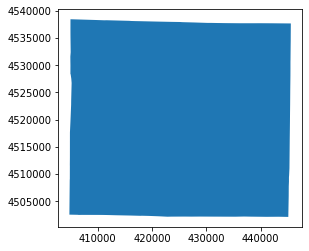

In [495]:
test_df=map_df[map_df.NAME=='1']
test_df.plot()

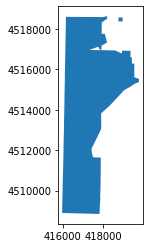

In [494]:
ptest_df=prec_df[prec_df.PRECINCT_e=='WOOSTER TWP 3']
ptest_df.plot()

In [493]:
map_df=map_df.to_crs(prec_df.crs)

In [491]:
map_df = map_df[map_df.geometry.notnull()]
prec_df = prec_df[prec_df.geometry.notnull()]

([], <a list of 0 Text yticklabel objects>)

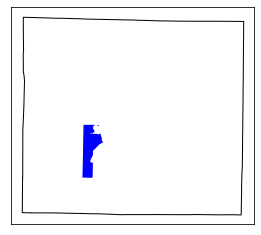

In [496]:
fig = Figure()
base = test_df.plot(color='white',edgecolor='black')
ptest_df.plot(ax=base, color='blue', figsize=(12, 12))
plt.xticks([])
plt.yticks([])

In [498]:
for key in top_dict:
    for p in top_dict[key]:
        print(p)

WOOSTER CITY 4-C
WOOSTER CITY 3-C
WOOSTER CITY 4-D
JEFF A
MAN 1 - E
MAN 1 - D
MIDDLETON TWP NORTH
PERRYSBURG X
BOWLING GREEN 3-E
JACKSON A
AMANDA E
MARION A
PRECINCT PERRY TWP NORTH
PRECINCT PERRY TWP SW
PRECINCT COLUMBIANA VIL D
BROADVIEW HEIGHTS-04-A
SOLON-05-A
SOLON-06-B
OLMSTED TOWNSHIP-00-G
STRONGSVILLE-01-F
STRONGSVILLE-03-D
EUCLID-01-D
BEACHWOOD-00-H
BEACHWOOD-00-F
SHAKER HEIGHTS-00-U
SHAKER HEIGHTS-00-J
SHAKER HEIGHTS-00-O
CLEVELAND-03-L
BRATENAHL-00-A
CLEVELAND-03-D
GARFIELD HEIGHTS-05-B
GARFIELD HEIGHTS-07-C
GARFIELD HEIGHTS-05-A
WARRENSVILLE HTS-03-A
BEDFORD-06-A
BEDFORD HEIGHTS-03-B
LAKEWOOD-01-H
LAKEWOOD-04-B
LAKEWOOD-04-D
MIDDLEBURG HEIGHTS-01-A
MIDDLEBURG HEIGHTS-04-A
MIDDLEBURG HEIGHTS-04-B
BROOKLYN HEIGHTS-00-A
PARMA-05-A
PARMA-02-E
NORTH OLMSTED-01-A
ROCKY RIVER-04-D
WESTLAKE-06-B
COLS 57-D
COLS 10-E
COLS 36-C
BEXLEY 1-B
COLS 14-A
COLS 40-C
WESTERVILLE 4-B
COLS 82-E
COLS 82-L
CANAL WIN-B
CANAL WIN-A
COLS 86-B
DUB 3-B
DUB 3-A
COLS 60-G
COLS 20-A
COLS 71-A
COLS 80-F
COL

In [499]:
ptest_1=prec_df[prec_df.PRECINCT_e=='WOOSTER CITY 4-C']
ptest_2=prec_df[prec_df.PRECINCT_e=='WOOSTER CITY 3-C']
ptest_3=prec_df[prec_df.PRECINCT_e=='WOOSTER CITY 4-D']

([], <a list of 0 Text yticklabel objects>)

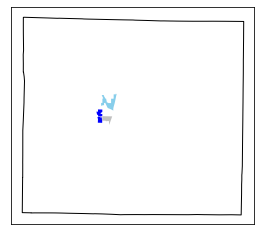

In [521]:
fig = Figure()
base = test_df.plot(color='white',edgecolor='black')
ptest_1.plot(ax=base, color='blue', figsize=(12, 12))
ptest_2.plot(ax=base, color='skyblue', figsize=(12, 12))
ptest_3.plot(ax=base, color='silver', figsize=(12, 12))
plt.xticks([])
plt.yticks([])

In [523]:
img_path='/Users/kristinalooper/WorkArea/insight/test_images/'
for key in top_dict:
    district_df=map_df[map_df.NAME==str(key)]
    precdf_0=prec_df[prec_df.PRECINCT_e==top_dict[key][0]]
    precdf_1=prec_df[prec_df.PRECINCT_e==top_dict[key][1]]
    precdf_2=prec_df[prec_df.PRECINCT_e==top_dict[key][2]]
    base = district_df.plot(color='white',edgecolor='black')
    precdf_0.plot(ax=base, color='blue', figsize=(12, 12))
    precdf_1.plot(ax=base, color='skyblue', figsize=(12, 12))
    precdf_2.plot(ax=base, color='silver', figsize=(12, 12))
    plt.xticks([])
    plt.yticks([])
    fname='district_'+str(key)+'.png'
    print(fname)
    plt.savefig(img_path+fname)
    plt.close()

district_1.png
district_2.png
district_3.png
district_4.png
district_5.png
district_6.png
district_7.png
district_8.png
district_9.png
district_10.png
district_11.png
district_12.png
district_13.png
district_14.png
district_15.png
district_16.png
district_17.png
district_18.png
district_19.png
district_20.png
district_21.png
district_22.png
district_23.png
district_24.png
district_25.png
district_26.png
district_27.png
district_28.png
district_29.png
district_30.png
district_31.png
district_32.png
district_33.png
district_34.png
district_35.png
district_36.png
district_37.png
district_38.png
district_39.png
district_40.png
district_41.png
district_42.png
district_43.png
district_44.png
district_45.png
district_46.png
district_47.png
district_48.png
district_49.png
district_50.png
district_51.png
district_52.png
district_53.png
district_54.png
district_55.png
district_56.png
district_57.png
district_58.png
district_59.png
district_60.png
district_61.png
district_62.png
district_63.png
d